# MIIA4101 - Semana 6
## Simulación y Optimización

### Consultoría Seguridad Vial

La Administración Distrital de Bogotá lo ha contactado con preocupación, pues es indispensable mejorar la respuesta a accidentes. Actualmente, la demora en el desplazamiento de patrullas contribuye a niveles adicionales de congestión y mal tratamiento de los incidentes. Como consultor, le han facilitado los archivos "*Registro_Nacional_De_Accidentalidad_201x.csv*" para los años 2013 a 2017, que se encuentran en la carpeta Accidentalidad.

<img src="files/foto.png">
<center>*Fuente*: http://images.cdn-eltiempo.com/bogota/cifra-de-accidentes-de-transito-en-bogota-2014/16422817</center>

El Distrito requiere un posicionamiento inteligente de hasta 8 centros de despacho de patrullas en la ciudad, de forma que pueda prestar el mejor servicio posible al mínimo costo. Lo anterior implica poder, al menos, llegar a toda localidad, y tener la menor cantidad posible de demanda insatisfecha. 

**ADVERTENCIA:** 
1. La metodología usada busca ilustrar algunas ideas dentro del contexto de la clase. NO corresponde con un abordaje real al problema planteado.

2. Algunos de los datos que se usan para el ejercicio se generan arbitrariamente, por lo que no deben interpretarse los resultados más allá de lo académico. 


## 1. Exploración preliminar de datos

### 1.1 Limpieza (aunque hubo limpieza previa)

In [62]:
import pandas as pd

accidentes = pd.read_pickle("Accidentes_Bogota_Fecha_Localidad.pkl")

accidentes["Gravedad del Accidente"].replace(
    to_replace={'SOLO DA\xc3\x91OS':"Danos", 'CON HERIDOS':"Heridos", 'CON MUERTOS':"Muertos"},inplace=True )

accidentes.rename(columns={"Gravedad del Accidente":"Gravedad"}, inplace=True)
accidentes.head()

,Lugar,Clase de Accidente,Clase de Choque,Gravedad
datetime,,,,
2013-01-01,Barrios Unidos,CHOQUE,VEHICULO,Danos
2013-01-01,Kennedy,CHOQUE,VEHICULO,Danos
2013-01-01,Ciudad Bolívar,ATROPELLO,VEHICULO,Heridos
2013-01-01,Suba,CHOQUE,VEHICULO,Danos
2013-01-01,San Cristóbal,CHOQUE,VEHICULO,Danos


### 1.2 Procesamiento básico

In [63]:
import datetime as dt

accidentes["Fecha"] = list(accidentes.index)

accidentes["DiaSem"] = (pd.to_datetime(accidentes["Fecha"])).dt.weekday
accidentes["Anio"] = (pd.to_datetime(accidentes["Fecha"])).dt.year
accidentes["Mes"] = (pd.to_datetime(accidentes["Fecha"])).dt.month

accidentes.drop(["Clase de Accidente", "Clase de Choque"], axis=1, inplace=True)
accidentes.head()

,Lugar,Gravedad,Fecha,DiaSem,Anio,Mes
datetime,,,,,,
2013-01-01,Barrios Unidos,Danos,2013-01-01,1,2013,1
2013-01-01,Kennedy,Danos,2013-01-01,1,2013,1
2013-01-01,Ciudad Bolívar,Heridos,2013-01-01,1,2013,1
2013-01-01,Suba,Danos,2013-01-01,1,2013,1
2013-01-01,San Cristóbal,Danos,2013-01-01,1,2013,1


### 1.3 Descriptivos generales

#### Accidentes por dia de la semana

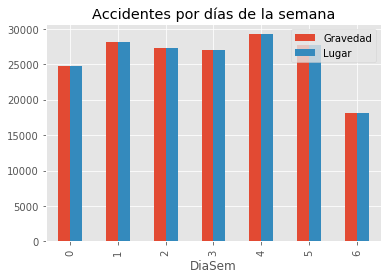

In [64]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Cuantos accidentes pasan cada dia de la semana (alguna diferencia?)
accidentes[["Gravedad","Lugar","DiaSem"]].groupby("DiaSem").count().plot(kind="bar")
plt.title("Accidentes por días de la semana")
plt.show()

#### Cantidad de accidentes por año

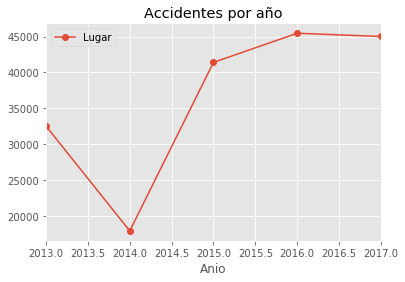

In [65]:
# Anio a anio, ha cambiado el prom accidentes?
accidentes[["Lugar","Anio"]].groupby("Anio").count().plot(style='o-', legend=True)
plt.title("Accidentes por año")
plt.show()

#### Accidentes por mes, según año

In [66]:
# Y por mes?
accid_anio = accidentes[["Lugar","Mes","Anio"]].groupby(["Mes","Anio"]).count().unstack()
accid_anio

Lugar                        
Anio  2013  2014  2015  2016  2017
Mes                               
1     2642  2023  2950  2805  3015
2     2753  2230  3503  3446  3782
3     2911  1423  3619  3503  3994
4     2927    60  3454  3832  3399
5     3115    58  3596  4037  4157
6     2583   549  3364  3822  3444
7     2661   328  3700  3760  3686
8     2675   183  3517  4016  3868
9     2683   650  3550  4077  3786
10    2665  3585  3735  4256  3942
11    2428  3453  3197  4194  3997
12    2489  3415  3222  3714  3944

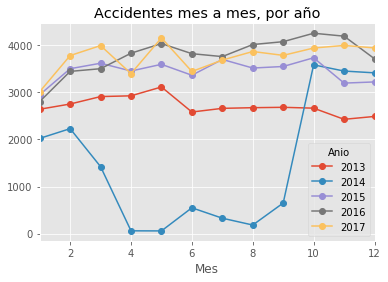

In [67]:
accid_anio.columns = accid_anio.columns.droplevel()
accid_anio.plot(style='o-')
plt.title("Accidentes mes a mes, por año")
plt.show()

#### Número de accidentes en cada fecha de cada año

In [68]:
# Y por dia?
accid_diario_anio = accidentes[["Lugar","Fecha", "Anio"]].groupby(["Anio","Fecha"]).count()
accid_diario_anio.columns = ["Cantidad (Temp)"]
accid_diario_anio.head()

Cantidad (Temp)
Anio Fecha                      
2013 2013-01-01               36
     2013-01-02               62
     2013-01-03               61
     2013-01-04               79
     2013-01-05               57

#### Cantidad de accidentes por localidad y gravedad

In [69]:
# Cuantos accidentes con solo dano Y cuantos con muerto o herido, POR LOCALIDAD, POR MES
grave = accidentes[["Lugar","Mes", "Gravedad"]].groupby(["Lugar","Gravedad"]).count()
grave.columns = ["Cantidad"]
grave.head(10)

Cantidad
Lugar          Gravedad          
Antonio Nariño Danos         1379
               Heridos       1036
               Muertos         42
Barrios Unidos Danos         3047
               Heridos       2408
               Muertos        110
Bosa           Danos         8376
               Heridos       6576
               Muertos        290
Chapinero      Danos         1711

#### Accidentes por localidad y fecha (para ver promedio diario)

In [70]:
# Cuantos accidentes hay por dia por LOCALIDAD
aux_demanda = accidentes[["Lugar","Fecha","Gravedad"]].groupby(["Lugar","Fecha"]).count()
#demanda_dia_prom_x_local = demanda_dia_prom_x_local.unstack()
aux_demanda.tail(9)

Gravedad
Lugar Fecha               
Usme  2017-12-23        12
      2017-12-24         3
      2017-12-25         7
      2017-12-26         8
      2017-12-27         3
      2017-12-28         1
      2017-12-29         5
      2017-12-30         2
      2017-12-31         2

In [71]:
# Esto conserva FECHA en filas y lanza LOCALIDAD a columnas, para promediar sobre ellas
aux_demanda_2 = aux_demanda.unstack().transpose()
aux_demanda_2.tail(7)

Lugar                Antonio Nariño  Barrios Unidos  Bosa  Chapinero  \
         Fecha                                                         
Gravedad 2017-12-25             1.0             2.0   7.0        1.0   
         2017-12-26             NaN             2.0  12.0        NaN   
         2017-12-27             1.0             5.0   7.0        2.0   
         2017-12-28             2.0             3.0   6.0        3.0   
         2017-12-29             2.0             5.0   9.0        4.0   
         2017-12-30             1.0             4.0   7.0        1.0   
         2017-12-31             1.0             2.0   6.0        1.0   

Lugar                Ciudad Bolívar  Engativá  Fontibón  Kennedy  \
         Fecha                                                     
Gravedad 2017-12-25             3.0       7.0       2.0      8.0   
         2017-12-26            10.0      13.0       9.0     16.0   
         2017-12-27            11.0      18.0       4.0     21.0   
         2017-12-28            11.0      18.0       8.0     10.0   
         2017-12-29            11.0      11.0       2.0     16.0   
         2017-12-30            10.0      13.0       6.0      6.0   
         2017-12-31            11.0       4.0       5.0      9.0   

Lugar                La Candelaria  Los Mártires  Puente Aranda  \
         Fecha                                                    
Gravedad 2017-12-25            NaN           1.0            2.0   
         2017-12-26            NaN           1.0            5.0   
         2017-12-27            NaN           1.0            4.0   
         2017-12-28            NaN           1.0            4.0   
         2017-12-29            NaN           1.0            5.0   
         2017-12-30            NaN           2.0            2.0   
         2017-12-31            NaN           1.0            3.0   

Lugar                Rafael Uribe Uribe  San Cristóbal  Santa Fe  Suba  \
         Fecha                                                           
Gravedad 2017-12-25                 3.0            2.0       1.0   8.0   
         2017-12-26                13.0           11.0       1.0  19.0   
         2017-12-27                 5.0           10.0       2.0  12.0   
         2017-12-28                 6.0            5.0       1.0  19.0   
         2017-12-29                 5.0            1.0       NaN  18.0   
         2017-12-30                 2.0            7.0       2.0  14.0   
         2017-12-31                 4.0            3.0       NaN   6.0   

Lugar                Sumapaz  Teusaquillo  Tunjuelito  Usaquén  Usme  
         Fecha                                                        
Gravedad 2017-12-25      NaN          NaN         4.0      6.0   7.0  
         2017-12-26      NaN          1.0         6.0      5.0   8.0  
         2017-12-27      NaN          1.0         1.0      8.0   3.0  
         2017-12-28      NaN          2.0         1.0      6.0   1.0  
         2017-12-29      NaN          4.0         5.0      5.0   5.0  
         2017-12-30      NaN          2.0         1.0      4.0   2.0  
         2017-12-31      NaN          2.0         1.0      8.0   2.0

In [72]:
# Aplicar PROMEDIO y DESVIACIÓN sobre columnas y REDONDEAR
prom_dem = aux_demanda_2.mean().apply(lambda x: int(round(x)))
desv_dem = aux_demanda_2.std(skipna=True, numeric_only=True).apply(lambda x: int(round(x)))

demanda_dia_x_local = pd.DataFrame( {"Prom.":prom_dem, "Desv.":desv_dem} )
demanda_dia_x_local.head(10)

,Desv.,Prom.
Lugar,,
Antonio Nariño,1,2
Barrios Unidos,2,4
Bosa,4,9
Chapinero,1,2
Ciudad Bolívar,4,9
Engativá,5,12
Fontibón,3,5
Kennedy,6,14
La Candelaria,0,1


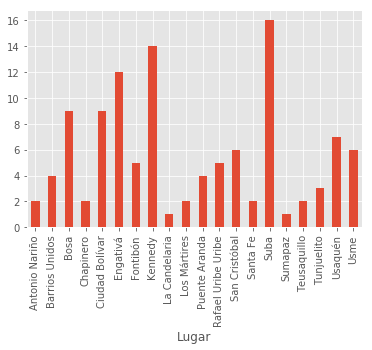

In [73]:
# Esta demanda diaria por LOCALIDAD, se hace promediando las 5x(~365) fechas
demanda_dia_x_local["Prom."].plot(kind="bar")
plt.show()

## 2. Modelo de optimización "miope" (i.e., valor esperado estático)

Consideremos el modelo más sencillo posible. Decidir en qué localidades instalar centros de despacho, y qué centros de despacho instalados atenderán a las demás localidades.

Establezcamos que se quiere *minimizar los costos de instalación, desplazamiento y penalización*, sujeto a:
* Se pueden instalar máximo 8 centros
* No se puede exceder la capacidad de un centro
* Se debe llegar a toda localidad
* (No se puede atender demanda desde centros no instalados)

#### Conjuntos:
$\mathcal{L}$: conjunto de localidades

#### Parámetros:
$q_i$: costo de instalar un recurso en la localidad $i \in \mathcal{L}$<br>
$d_{ij}$:costo de desplazamiento la localidad $i \in \mathcal{L}$ a la $j \in \mathcal{L}$<br>
$M_j$: penalidad unitaria por demanda insatisfecha en la localidad $i \in \mathcal{L}$<br>
$k$: capacidad de un recurso<br>
$s_j$: demanda de la localidad $j \in \mathcal{L}$<br>

#### Variables
$x_i$: si se instala un recurso en la localidad $i \in \mathcal{L}$<br>
$y_{ij}$: si un recurso en la localidad $i \in \mathcal{L}$ atiende a la localidad $j \in \mathcal{L}$<br>
$\delta_j$: demanda insatisfecha en la localidad $j \in \mathcal{L}$<br>

#### Modelo:
$$\min \sum\limits_{i\in\mathcal{L}}q_{i}x_{i}+\sum\limits_{i\in\mathcal{L}}\sum\limits_{j\in\mathcal{L}}d_{ij}y_{ij}+\sum\limits_{j\in\mathcal{L}}M_j \delta_j$$
<br>
<center>s.a,</center><br>

$$\sum\limits_{i\in\mathcal{j}}x_{i} \leq 8$$

$$\sum\limits_{i\in\mathcal{j}}y_{ij} \geq s_{j} - \delta_{j}, \forall j \in \mathcal{L}$$

$$\sum\limits_{i\in\mathcal{L}}y_{ij} \leq 1, \forall j \in \mathcal{L}$$

$$y_{ij} \leq k x_{i}, \forall i \in \mathcal{L}, j \in \mathcal{L}$$

$$y_{ij} \leq k z_{ij}, \forall i \in \mathcal{L}, j \in \mathcal{L}$$

<br>

$$\delta_j \geq 0, \forall j \in \mathcal{L}$$

$$x_{i} \in \left\{0,1\right\}, \forall i \in \mathcal{L}$$

$$y_{ij} \geq 0, \forall i \in \mathcal{L}, j \in \mathcal{L}.$$

$$z_{ij} \in \left\{0,1\right\}, \forall i \in \mathcal{L}, j \in \mathcal{L}.$$

In [74]:
from gurobipy import *
from math import sqrt

# Función que calcula distancia (útil luego)
def get_dist(coo_A, coo_B):
    return sqrt( (coo_A[0]-coo_B[0])**2 + (coo_A[1]-coo_B[1])**2 )

# Coordenadas de las localidades
coo = pd.read_pickle("coordenadas.pkl")
# Definición del modelo de optimización
mPB = Model("Patrullas_Bogota")
mPB.setParam("OutputFlag",0)

# Conjuntos:
Loc = list(demanda_dia_x_local["Prom."].index)

In [75]:
# Parametros
q = 1e2
M = 1e5
dist = {(i,j):round(1e3*get_dist(coo[i],coo[j])) for i in Loc for j in Loc}
k = 15
s = demanda_dia_x_local["Prom."]

# Variables

y = {(i,j):mPB.addVar(vtype=GRB.CONTINUOUS, name="Y_"+i+"_"+j) for i in Loc for j in Loc}
x = {i:mPB.addVar(vtype=GRB.BINARY, name="X_"+i) for i in Loc}
z = {(i,j):mPB.addVar(vtype=GRB.BINARY, name="Z_"+i+"_"+j) for i in Loc for j in Loc}
delta = {j:mPB.addVar(vtype=GRB.CONTINUOUS, name="d_"+j) for j in Loc}

# Restricciones

# No más de 8 centros
mPB.addConstr( quicksum(x[i] for i in Loc) <= 8 )

for j in Loc:
    # Lo que se envia desde los i a cada j debe satisfacer la demanda; o no!
    mPB.addConstr( quicksum(y[i,j] for i in Loc) + delta[j] >= s[j] )
    
    # Una localidad debe tener un único centro de depacho asignado 
    mPB.addConstr( quicksum(z[i,j] for i in Loc) <= 1 )
for i in Loc:
    # Lo que se envía desde un centro i (instalado) no puede superar capacidad k
    mPB.addConstr( quicksum(y[i,j] for j in Loc) <= k*x[i] )
    for j in Loc:
        mPB.addConstr( y[i,j] <= k*z[i,j] )

# Funcion objetivo
instal = quicksum(q*x[i] for i in Loc)
desplaz = quicksum(dist[i,j]*y[i,j] for i in Loc for j in Loc)
penal = quicksum(M*delta[j] for j in Loc)

FO = mPB.setObjective(instal+desplaz+penal, GRB.MINIMIZE)
mPB.optimize()

In [76]:
# Pre-procesamiento resultados
X = [x[i].x>.5 for i in Loc]
D = [round(delta[j].x) for j in Loc]
S = [round(x[i].x)*round((k-sum(y[i,j].x for j in Loc))) for i in Loc]
Y = [[i for i in Loc if z[i,j].x>.5] for j in Loc]
Y = [k[0] for k in Y]
Kap = [365*sum(y[i,j].x for i in Loc) for j in Loc]

# Resumen
resumen = {"1. Hay centro?":X, "2. Atendido por?":Y, "3. Dem. Insat.":D, "4. Slack":S, "5. Cap.":Kap}
result = pd.DataFrame(resumen, index=[l for l in Loc])
result["5. Cap."] = result["5. Cap."] + result["4. Slack"]
Insat_Tot = 365*result["3. Dem. Insat."].sum()
result

,1. Hay centro?,2. Atendido por?,3. Dem. Insat.,4. Slack,5. Cap.
Antonio Nariño,True,Antonio Nariño,0,0,730.0
Barrios Unidos,False,Usaquén,0,0,1460.0
Bosa,True,Bosa,0,1,3286.0
Chapinero,False,Usaquén,0,0,730.0
Ciudad Bolívar,True,Ciudad Bolívar,0,3,3288.0
Engativá,True,Engativá,0,1,4381.0
Fontibón,False,Bosa,0,0,1825.0
Kennedy,True,Kennedy,0,0,5110.0
La Candelaria,False,Kennedy,0,0,365.0
Los Mártires,False,Antonio Nariño,0,0,730.0


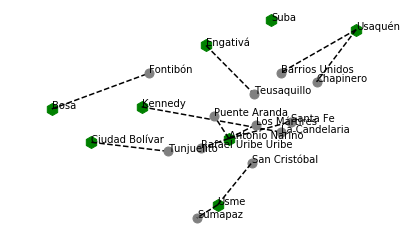

In [77]:
# Visualización
for i in x:
    if x[i].x>.5:
        plt.plot(coo[i][0],coo[i][1],'h',color='g',MarkerSize=12)
        for j in Loc:
            if y[i,j].x>.5:
                plt.plot([coo[i][0],coo[j][0]], [coo[i][1],coo[j][1]],'--',color='k')
    else:
        plt.plot(coo[i][0],coo[i][1],'o',color="grey",MarkerSize=9)
    plt.text(coo[i][0],coo[i][1],i)
plt.axis('off')
plt.show()

## 3. Simulación (prueba de desempeño de la solución)

Supongamos que uno de los analistas del grupo considera que es importante la estacionalidad por días y por meses.

In [78]:
lista = []
for i in range(2013,2018):
    id_filas = (accidentes["Anio"] == i)
    id_cols = ["Lugar","Mes","DiaSem","Gravedad"]
    lista.append( accidentes[id_cols][id_filas].groupby(["Lugar","Mes","DiaSem"]).count() )
LMD = pd.concat( lista, axis=1 )
LMD.columns = [i for i in range(2013,2018)]
LMD.head(10)

2013  2014  2015  2016  2017
Lugar          Mes DiaSem                              
Antonio Nariño 1   0        7.0   2.0   4.0   5.0   5.0
                   1        7.0   4.0   7.0   3.0   7.0
                   2        5.0   4.0   5.0   3.0   7.0
                   3        5.0   6.0   4.0   6.0   6.0
                   4        7.0   6.0   8.0   4.0   4.0
                   5        3.0   6.0  13.0  10.0   3.0
                   6        1.0   3.0   3.0   4.0   7.0
               2   0        4.0   4.0  12.0   7.0   7.0
                   1        3.0   4.0  11.0   9.0   9.0
                   2        6.0   4.0  12.0   5.0   8.0

### Un analista dice que 2014 es ¡atípico!

Entonces pasamos a calcular media y desviación por MES, DIA SEMANA, y LOCALIDAD, excluyendo 2014.

In [79]:
LMD.drop([2014], axis=1, inplace=True)
LMD["Prom"] = LMD.mean(axis=1, skipna=True, numeric_only=True)
LMD["Desv"] = LMD.std(axis=1, skipna=True, numeric_only=True)
LMD.loc[("Sumapaz",3,),:]

,2013,2015,2016,2017,Prom,Desv
DiaSem,,,,,,
1,NaN,2.0,1.0,1.0,1.333333,0.471405
2,NaN,NaN,1.0,NaN,1.000000,0.000000
3,1.0,NaN,NaN,1.0,1.000000,0.000000
4,NaN,NaN,NaN,1.0,1.000000,0.000000
5,NaN,NaN,NaN,1.0,1.000000,0.000000
6,NaN,1.0,NaN,NaN,1.000000,0.000000


In [80]:
LMD = LMD[["Prom","Desv"]]
LMD.head()

Prom      Desv
Lugar          Mes DiaSem                
Antonio Nariño 1   0       5.25  1.089725
                   1       6.00  1.732051
                   2       5.00  1.414214
                   3       5.25  0.829156
                   4       5.75  1.785357

### OJO: Forma INEFICIENTE de plantear la simulación

In [89]:
tuplas = [(l,m,wd) for l in Loc for m in range(12) for wd in range(7)]
simu = pd.DataFrame(columns=['Realizacion'], index=pd.MultiIndex.from_tuples(tuplas,names=["Loc","Month","Wd"]))
simu.head()

Realizacion
Loc            Month Wd            
Antonio Nariño 0     0          NaN
                     1          NaN
                     2          NaN
                     3          NaN
                     4          NaN

In [90]:
from numpy.random import normal

dia_actual = dt.datetime(2018,1,1)

# Barrer día a día, localidad por localidad
# Y agregar POR CELDAS: horrible!

for i in range(18): # Debería ser 365 pero MUERE
    this_wd = dia_actual.weekday()
    this_mo = dia_actual.month    
    for this_loc in Loc:
        try:
            this_mean = LMD.loc[(this_loc, this_mo, this_wd), "Prom"]
            this_dev = LMD.loc[(this_loc, this_mo, this_wd), "Desv"]
            
            num_acci = max( [round(normal(this_mean, this_dev)), 0 ] )              
        except:
            num_acci = 0
        
        simu.loc[((this_loc, this_mo, this_wd)),"Realizacion"] = num_acci
    
    dia_actual += dt.timedelta(days=1)  
simu.dropna(how="all", inplace=True)
simu.head(9)

Realizacion
Loc            Month Wd            
Antonio Nariño 1     0            6
                     1            5
                     2            7
                     3            6
                     4            7
                     5            7
                     6            5
Barrios Unidos 1     0            7
                     1           16

### Forma eficiente
#### Declarar un DataFrame vacío

In [91]:
simu = pd.DataFrame(columns=['Realizacion'], index=pd.MultiIndex.from_tuples(tuplas,names=["Loc","Month","Wd"]))
simu.head()

Realizacion
Loc            Month Wd            
Antonio Nariño 0     0          NaN
                     1          NaN
                     2          NaN
                     3          NaN
                     4          NaN

#### Ejecutar simulación (5 iteraciones de una)

In [92]:
from numpy.random import normal
incr=5
for i in range(10):
    simu["Sim_"+str(i)] = LMD.apply(lambda row: normal(row["Prom"]+incr, row["Desv"]), axis=1 )

#simu.drop(["Realizacion"], axis=1, inplace=True)
simu.dropna(how="all", inplace=True)
sim = simu.groupby(level=[0]).sum()
sim.head(10)

,Sim_0,Sim_1,Sim_2,Sim_3,Sim_4,Sim_5,Sim_6,Sim_7,Sim_8,Sim_9
Loc,,,,,,,,,,
Antonio Nariño,878.379445,895.362487,889.819239,931.252265,927.692831,869.239024,910.971946,894.343838,879.029836,961.003409
Barrios Unidos,1520.450477,1578.227854,1510.131036,1560.943106,1615.531760,1537.938229,1479.566135,1487.100327,1502.386102,1519.442960
Bosa,3578.132866,3694.372497,3554.892075,3614.931705,3447.924650,3535.888853,3556.501336,3472.440041,3465.050969,3569.821840
Chapinero,1042.674077,1050.236400,1025.730734,1036.215714,1040.585375,1026.522788,1001.596190,1067.964436,1023.586417,1019.526539
Ciudad Bolívar,3656.477717,3669.698024,3693.110870,3719.663617,3715.062062,3723.057791,3750.599587,3819.501200,3759.463908,3810.358692
Engativá,4695.102309,4725.113093,4522.887321,4589.537825,4588.510355,4516.496121,4423.676102,4705.297590,4587.918267,4666.939987
Fontibón,2173.206754,2176.656789,2207.784780,2204.527899,2118.964798,2273.155557,2223.422575,2214.333538,2147.523781,2278.047915
Kennedy,5583.770508,5327.610244,5409.644386,5467.679827,5800.029941,5251.056860,5222.676540,5499.063359,5582.578705,5426.609515
La Candelaria,541.222615,538.301116,519.418128,520.726883,534.237858,535.808213,533.961988,522.533014,540.781081,529.730522


### Evaluar desempeño a lo largo de las realizaciones

In [85]:
Eval = sim
Eval["Cap"] = result["5. Cap."]
Eval

,Sim_0,Sim_1,Sim_2,Sim_3,Sim_4,Sim_5,Sim_6,Sim_7,Sim_8,Sim_9,Cap
Loc,,,,,,,,,,,
Antonio Nariño,905.091637,916.324884,871.977613,898.138438,908.434002,908.579091,870.297450,912.013749,887.359145,883.884761,730.0
Barrios Unidos,1593.924425,1539.834417,1615.917788,1544.386320,1492.034701,1582.084807,1552.029154,1597.127932,1523.379133,1557.192615,1460.0
Bosa,3522.962430,3516.428563,3524.465087,3546.242994,3474.619360,3581.802141,3645.714263,3633.501594,3582.358947,3407.409800,3286.0
Chapinero,1019.638502,1041.632409,1033.982728,1066.982542,1007.547259,1017.850573,1043.220014,994.052766,1046.902758,1059.028770,730.0
Ciudad Bolívar,3652.764219,3764.803881,3747.240782,3758.990992,3677.446265,3707.787714,3836.883366,3803.787961,3683.518167,3694.121749,3288.0
Engativá,4534.717968,4454.583170,4614.028464,4771.298144,4459.685628,4572.236447,4637.335355,4671.223668,4565.806152,4523.697806,4381.0
Fontibón,2187.798446,2197.721137,2373.966699,2193.603828,2185.884054,2192.334832,2255.875095,2152.066620,2265.613734,2250.706422,1825.0
Kennedy,5752.284502,5415.017271,5259.479647,5489.451518,5402.593966,5647.686401,5556.978107,5627.656408,5402.332340,5533.866661,5110.0
La Candelaria,540.117341,539.555271,530.658275,528.252274,533.246997,526.643118,535.607283,532.223565,533.507944,524.123772,365.0


In [86]:
for i in range(10):
    Eval["Sim_"+str(i)] = Eval["Sim_"+str(i)] - Eval["Cap"]
    Eval["Sim_"+str(i)][ Eval["Sim_"+str(i)]<=0 ] = 0
Eval

,Sim_0,Sim_1,Sim_2,Sim_3,Sim_4,Sim_5,Sim_6,Sim_7,Sim_8,Sim_9,Cap
Loc,,,,,,,,,,,
Antonio Nariño,175.091637,186.324884,141.977613,168.138438,178.434002,178.579091,140.297450,182.013749,157.359145,153.884761,730.0
Barrios Unidos,133.924425,79.834417,155.917788,84.386320,32.034701,122.084807,92.029154,137.127932,63.379133,97.192615,1460.0
Bosa,236.962430,230.428563,238.465087,260.242994,188.619360,295.802141,359.714263,347.501594,296.358947,121.409800,3286.0
Chapinero,289.638502,311.632409,303.982728,336.982542,277.547259,287.850573,313.220014,264.052766,316.902758,329.028770,730.0
Ciudad Bolívar,364.764219,476.803881,459.240782,470.990992,389.446265,419.787714,548.883366,515.787961,395.518167,406.121749,3288.0
Engativá,153.717968,73.583170,233.028464,390.298144,78.685628,191.236447,256.335355,290.223668,184.806152,142.697806,4381.0
Fontibón,362.798446,372.721137,548.966699,368.603828,360.884054,367.334832,430.875095,327.066620,440.613734,425.706422,1825.0
Kennedy,642.284502,305.017271,149.479647,379.451518,292.593966,537.686401,446.978107,517.656408,292.332340,423.866661,5110.0
La Candelaria,175.117341,174.555271,165.658275,163.252274,168.246997,161.643118,170.607283,167.223565,168.507944,159.123772,365.0


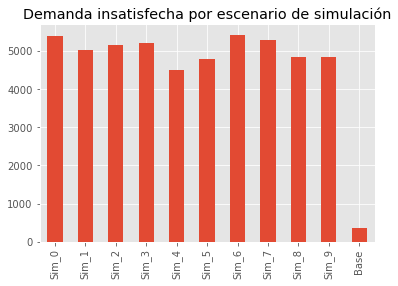

In [87]:
H = Eval.sum()
H.drop("Cap", inplace=True)
H["Base"] = Insat_Tot
H.plot(kind="bar")
plt.title("Demanda insatisfecha por escenario de simulación")
plt.show()

In [88]:
print("La demanda insatisfecha promedio es: "+str(H.mean()))

La demanda insatisfecha promedio es: 4620.548014366762
